In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Data import

#### Control Urine data

In [2]:
dataC = pd.read_excel("Compile400.xlsx", sheet_name='Rishikesh blood control')
#dataC.head()
dataC = dataC[['UHID','Results Ramja','AIIMS BACTEC Result']]
dataC.columns = ['UHID','RAMJA','AIIMS']
#dataC.head()
dataC.shape

(42, 3)

In [26]:
#display(dataC)

In [3]:
dataC.isnull().sum()

UHID     0
RAMJA    0
AIIMS    0
dtype: int64

In [4]:
dataC = dataC.drop_duplicates(subset=['UHID'])
dataC.shape

(42, 3)

In [22]:
#display(dataC)

In [5]:
data = dataC
data.shape

(42, 3)

In [6]:
data.isnull().sum()

UHID     0
RAMJA    0
AIIMS    0
dtype: int64

In [72]:
#display(data)

#### Function for text cleaning in columns

In [7]:
import re
def cleanup(text):
    text = str(text)
    text = text.upper()
    text = text.replace(".", " ")
    text = text.replace(" AND", ",")
    text = text.replace(" &", ",")
    text = text.replace("POLYMICROBIAL (", "")
    text = text.replace("AUROGENOSA", "AERUGINOSA")
    text = text.replace("NO GROWTH", "STERILE")
    text = re.sub(r'\s+', ' ', text)  # Use re.sub for regular expression replacement
    text = text.strip()
    return text


#### Dictionary of bactrial names

In [8]:
bacteriatypes = {
    "COLI" : 'Escherichia coli', 
    "PNE" : 'Klebsiella pneumoniae',
    "AERUGI" : 'Pseudomonas aeruginosa',
    "BAUM" : 'Acinetobacter baumannii', 
    "MIRABIL" : 'Proteus mirabilis', 
    "FAECALI" : 'Enterococcus faecalis', 
    "AUREUS" : 'Staphylococcus aureus', 
    "SAPROPHY" : 'Staphylococcus saprophyticus',
    "STERI" : 'Sterile',
    "CONTA" : 'Contamination',
    "NAN" : 'NAN'
}

#### Fucntion to check if test string present in main string

In [9]:
#..FUNCTION TO CHECK IF TEST STRINGS(S1 OR S2) PRESENT IN MAIN STRING 
def check(mainstring, s1, s2):
    if (mainstring.count(s1) > 0 or mainstring.count(s2) > 0):
        #print("YES")
        return(1)
    else:
        #print("NO")
        return(0)

#### Data processing function

In [10]:
def processdata(data, test):
    #.........Get UHID and Test data only..........#
    df = data[['UHID',test]]

    #........Clean the columns AIIMS and RAMJA names......#
    df['clean'+test] = df[test].apply(cleanup)

    #...........Get individual bactrial data for infection and serility......#
    genus = ["ESCHER","KLEBS","PSEUDO","ACINE","PROT","ENTER","AURE","SAPRO","STERI","CONTA","NAN"]
    species = ["COLI", "PNE", "AERUGI", "BAUM", "MIRABIL", "FAECALI", "AUREUS", "SAPROPHY", "STERI","CONTA","NAN"]
    for s1, s2 in zip(genus,species):
        df[s2] = df['clean'+test].apply(lambda x: check(x, s1, s2))

    df.rename(columns=bacteriatypes, inplace=True) #change column names

    #....add a column named 'Others' contain values other than assigend catagories
    df['Others'] = (df[['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus','Sterile','Contamination','NAN']] == 0).all(axis=1).astype(int)

    #...Get all infections positive (bacteria + others ) in AIIMS
    df['Positive'] = (df[['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus','Others']] == 1).any(axis=1).astype(int)

    #...Get all Negatives (Sterile + contaminated ) in AIIMS
    df['Negative'] = (df[['Sterile','Contamination']] == 1).any(axis=1).astype(int)
    
    return df

#### Fetch the processed dataset for RAMJA and AIIMS

In [11]:
test = ['RAMJA', 'AIIMS']

# Create a dictionary to store results dynamically
df_dict = {}

# Store the result with a dynamic key
for t in test:
    df_dict['df' + t] = processdata(data, t)

df_R = df_dict['dfRAMJA']
df_A = df_dict['dfAIIMS']


### RAMJA Subsets and Analysis : df_NonNaN_R, 

In [12]:
df_NonNaN_R = df_R.dropna(subset=['RAMJA']) # Nonnull Dataset from Ramaja
df_Pos_R = df_NonNaN_R[df_NonNaN_R['Positive'] == 1] # Positive ramja dataset
df_Neg_R = df_NonNaN_R[df_NonNaN_R['Negative'] == 1] # Negative Ramja dataset
df_Conta_R = df_NonNaN_R[df_NonNaN_R['Contamination'] == 1] # Contaminated Ramja dataset
df_Other_R = df_NonNaN_R[df_NonNaN_R['Others'] == 1] # Others Ramja dataset

In [13]:
#....After Dopping NaN these two set of values should be equal
print(df_NonNaN_R['Positive'].value_counts())
print(df_NonNaN_R['Negative'].value_counts())

Positive
0    40
1     2
Name: count, dtype: int64
Negative
1    40
0     2
Name: count, dtype: int64


### AIIMS subsets and analysis 

In [14]:
df_NonNaN_A = df_A.dropna(subset=['AIIMS']) # Nonnull Dataset from Ramaja
df_Pos_A = df_NonNaN_A[df_NonNaN_A['Positive'] == 1] # Positive ramja dataset
df_Neg_A = df_NonNaN_A[df_NonNaN_A['Negative'] == 1] # Negative Ramja dataset
df_Conta_A = df_NonNaN_A[df_NonNaN_A['Contamination'] == 1] # Contaminated Ramja dataset
df_Other_A = df_NonNaN_A[df_NonNaN_A['Others'] == 1] # others Ramja dataset

In [15]:
#....After Dopping NaN these two set of values should be equal
print(df_NonNaN_A['Positive'].value_counts())
print(df_NonNaN_A['Negative'].value_counts())

Positive
0    40
1     2
Name: count, dtype: int64
Negative
1    40
0     2
Name: count, dtype: int64


### Common analysis

In [16]:
#...Concordance: Get same type of infections in both RAMJA and AIIMS
df_R_temp1  = df_R[['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus']]
df_A_temp1  = df_A[['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus']]
df_C = data[['UHID','RAMJA','AIIMS']]
df_C['concordance'] = (df_R_temp1 & df_A_temp1).any(axis=1).astype(int)
df_C.head()

,UHID,RAMJA,AIIMS,concordance
0,20240091354,Sterile,No Growth,0
1,20240066897,Sterile,No Growth,0
2,20230008215,Sterile,No Growth,0
3,20240039512,Sterile,No growth,0
4,20240043469,Sterile,No growth,0


In [17]:
temp_R = df_R[['UHID','Positive','Negative']].rename(columns={'Positive':'Positive_R', 'Negative':'Negative_R'})
temp_A = df_A[['UHID','Positive','Negative']].rename(columns={'Positive':'Positive_A', 'Negative':'Negative_A'})
temp_C = pd.merge(temp_A, temp_R, how='inner', on='UHID')
df_C = pd.merge(df_C, temp_C, how='inner', on='UHID')


In [18]:
df_NonNaN_C = df_C.dropna(subset=['RAMJA','AIIMS'])
df_NonNaN_C.head()

,UHID,RAMJA,AIIMS,concordance,Positive_A,Negative_A,Positive_R,Negative_R
0,20240091354,Sterile,No Growth,0,0,1,0,1
1,20240066897,Sterile,No Growth,0,0,1,0,1
2,20230008215,Sterile,No Growth,0,0,1,0,1
3,20240039512,Sterile,No growth,0,0,1,0,1
4,20240043469,Sterile,No growth,0,0,1,0,1


In [25]:
#display(df_NonNaN_C)

In [19]:
#...NonNan common data set
df_NonNaN_C = df_C.dropna(subset=['RAMJA','AIIMS'])

#...RAMJA positives
df_Pos_C_R = df_NonNaN_C[(df_NonNaN_C['Positive_R'] == 1)][['UHID', 'RAMJA', 'AIIMS']]

#...AIIMS positives
df_Pos_C_A = df_NonNaN_C[(df_NonNaN_C['Positive_A'] == 1)][['UHID', 'RAMJA', 'AIIMS']]

#...RAMJA Negative
df_Neg_C_R = df_NonNaN_C[(df_NonNaN_C['Negative_R'] == 1)][['UHID', 'RAMJA', 'AIIMS']]

#...AIIMS Negative
df_Neg_C_A = df_NonNaN_C[(df_NonNaN_C['Negative_A'] == 1)][['UHID', 'RAMJA', 'AIIMS']]

#...Both positives
df_Pos_C = df_NonNaN_C[(df_NonNaN_C['Positive_R'] == 1) & (df_NonNaN_C['Positive_A'] == 1)][['UHID', 'RAMJA', 'AIIMS']]

#...Both Negatives
df_Neg_C = df_NonNaN_C[(df_NonNaN_C['Negative_R'] == 1) & (df_NonNaN_C['Negative_A']==1)][['UHID', 'RAMJA', 'AIIMS']]

#...Common type of infection
df_concordance = df_C[df_C['concordance'] == 1][['UHID','RAMJA','AIIMS']][['UHID', 'RAMJA', 'AIIMS']]

#...Ramja Positive and AIIMS negative
df_Pos_R_Neg_A = df_C[(df_C['Positive_R']==1) & (df_C['Negative_A']==1)][['UHID', 'RAMJA', 'AIIMS']]

#...Ramja Negative and AIIMS Positive
df_Neg_R_Pos_A = df_C[(df_C['Positive_A']==1) & (df_C['Negative_R']==1)][['UHID', 'RAMJA', 'AIIMS']]

In [20]:
df_Neg_R_Pos_A.head()

,UHID,RAMJA,AIIMS
27,20240105203,Sterile,Staphylococcus haemolyticus


In [22]:
# df_diagnosis = pd.merge(df_NonNaN_C, df_diagnosis,  how='inner', on="UHID")
# df_diagnosis.head()

### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix

y_true = df_NonNaN_C['Positive_A']
y_pred = df_NonNaN_C['Positive_R']
# y_true = df_diagnosis['Diagnosis']
# y_pred = df_diagnosis['Positive_A']

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[39  1]
 [ 1  1]]


In [22]:
sum(sum(cm))

42

In [23]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn,fp,fn,tp)

(39, 1, 1, 1)

In [24]:
t_cm = np.array([tp, fp, fn, tn]).reshape(2,2)
t_cm

array([[ 1,  1],
       [ 1, 39]], dtype=int64)

In [25]:
df_cm =pd.DataFrame(t_cm,index=['RAMJA Positive','RAMJA Negative'], columns= ['AIIMS Positive','AIIMS Negative'])
df_cm

,AIIMS Positive,AIIMS Negative
RAMJA Positive,1,1
RAMJA Negative,1,39


### Chi-Square test

In [26]:
# Example of the Chi-Squared Test
from scipy.stats import chi2_contingency
#table = [[1, 1],[1,  39]]
table = t_cm
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=1.897, p=0.16846
Probably independent


#### Scores

In [27]:
def scores(y_true, y_pred):
        #y_pred = self.fit(x_train, x_test, y_train)
        from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
        
        cm = confusion_matrix(y_true,y_pred)
        
        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                
        #.....................Accuracy......................#
        #accur = accuracy_score(y_test,y_pred)
        accur = (tp + tn)/(tp+tn+fp+fn)
        
       #.....................Senstivity.....................#
        sens = tp/(tp + fn) if (tp + fn) > 0 else 0

        #.....................Specificity...................#
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

        #.....................Precision...................#
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        #.....................Recall...................#      
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        #.....................f1_score...................# 
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        #..........Positive predictive value (PPV)...........#
        PPV = tp/(tp + fp) if (tp + fp) > 0 else 0

        #..........negative predictive value (NPV)...........#
        NPV = tn/(tn + fn) if (tn + fn) > 0 else 0
        
        #..........Positive Likelihood ratio (PLR)...........#
        PLR = sens/(1-spec)

        #..........Negative Likelihood ratio (NLR)...........#
        NLR = (1-sens)/spec

        errorList = np.array([accur, sens, spec, precision, recall, f1_score, PPV, NPV, PLR, NLR])
        scoreid = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision','Recall','F1 Score','PPV', 'NPV', 'PLR', 'NLR']
        df_scores = pd.DataFrame(errorList,index=scoreid, columns= ['Scores'])
        
        return(df_scores)

In [28]:
df_score = scores(y_true,y_pred)
df_score

,Scores
Accuracy,0.952381
Sensitivity,0.500000
Specificity,0.975000
Precision,0.500000
Recall,0.500000
F1 Score,0.500000
PPV,0.500000
NPV,0.975000
PLR,20.000000
NLR,0.512821


In [29]:
import scipy.stats
import math
samplesize = df_NonNaN_C.shape[0]
precision = 0.07
prevalence = 0.5
sensitivity = df_score.loc['Sensitivity'].values
specificity = df_score.loc['Specificity'].values
print(f"Sample Size = {samplesize}, Sensitivity = {sensitivity}, Specificity = {specificity}")

Sample Size = 42, Sensitivity = [0.5], Specificity = [0.975]


In [30]:
Zprev = math.sqrt((samplesize*precision**2)/(prevalence*(1-prevalence)))
Pvalue = scipy.stats.norm.sf(Zprev)
print(f"Zprev = {Zprev:0.4f}, P value = {Pvalue:0.4f}")

Zprev = 0.9073, P value = 0.1821


In [33]:
Zsens = math.sqrt((samplesize*precision**2*prevalence)/(sensitivity*(1-sensitivity)))
PvalueSens = scipy.stats.norm.sf(Zsens)
print(f"Zprev = {Zsens:0.4f}, P value = {PvalueSens:0.4f}")

Zprev = 0.6416, P value = 0.2606


In [34]:
Zspes = math.sqrt((samplesize*precision**2*(1-prevalence))/(specificity*(1-specificity)))
PvalueSpes = scipy.stats.norm.sf(Zspes)
print(f"Zprev = {Zspes:0.4f}, P value = {PvalueSpes:0.4f}")

Zprev = 2.0546, P value = 0.0200


#### Samples detail

In [36]:
samplesDetail = {
    #"Total Samples": [data.shape[0],data.shape[0]],
    #"Blank Results": [data['RAMJA'].isnull().sum(axis=0), data['AIIMS'].isnull().sum(axis=0)],
    #"Non-Blank Results": [data['RAMJA'].count(),data['AIIMS'].count()],
    #"Contaminated Samples [-Ve]": [df_NonNaN_R['Contamination'].sum(),df_NonNaN_A['Contamination'].sum()],
    #"Others [+Ve]": [df_NonNaN_R['Others'].sum(),df_NonNaN_A['Others'].sum()],
    "Total common samples":  [df_NonNaN_C.shape[0], df_NonNaN_C.shape[0]],
    #"Useful Samples":[df_R_clean.shape[0], df_A_clean.shape[0]],
    "Positive": [df_NonNaN_C['Positive_R'].sum(),df_NonNaN_C['Positive_A'].sum()],
    "Negative": [df_NonNaN_C['Negative_R'].sum(),df_NonNaN_C['Negative_A'].sum()],
    "Common Positive": [tp,tp],
    "Concordance [Common bacteria]": [df_C['concordance'].sum()],
    "Common Negative": [tn,tn],
    "RAMJA Positive and AIIMS Negative":[df_Pos_R_Neg_A.shape[0]],
    "RAMJA Negative and AIIMS Positive":[df_Neg_R_Pos_A.shape[0]]
    
}

In [37]:
df_samplesDetail = pd.DataFrame(samplesDetail, index=['RAMJA','AIIMS']).T
df_samplesDetail

,RAMJA,AIIMS
Total common samples,34,34
Positive,0,3
Negative,34,31
Common Positive,0,0
Concordance [Common bacteria],0,0
Common Negative,31,31
RAMJA Positive and AIIMS Negative,0,0
RAMJA Negative and AIIMS Positive,3,3


In [38]:
# Write the DataFrames to an Excel file
with pd.ExcelWriter('UrineControlmatrices.xlsx') as writer:
    df_samplesDetail.to_excel(writer, sheet_name='SamplesDetail', index=True)
    df_cm.to_excel(writer, sheet_name='ConfusionMatrix', index=True)
    df_score.to_excel(writer, sheet_name='Scores', index=True)
    #df_cm_sym.to_excel(writer, sheet_name='Ramja positive with symptoms', index=True)
    #df_score_sym.to_excel(writer, sheet_name='Scores with symptoms', index=True)

### Symptoms analysis

In [32]:
data_sym = dataset[['UHID','Abdominal pain', 'BurningMicturition','Urinating often','Vaginal irritation']]
data_sym.shape

(131, 5)

In [33]:
data_sym.head()

,UHID,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation
0,20220065432,Yes,Yes,Yes,No
1,20240016182,Yes,No,no,no
2,20230125389,No,Yes,No,No
3,20180022685,No,Yes,No,Yes
4,20201415102,No,No,No,No


#### Data cleaning for correlation of catagorical matrix

In [34]:
# drop rows conatining any nullvalue
data_sym = data_sym.dropna()

# Define undesired symbols (as a regex pattern)
undesired_symbols = '[-_@#$]'

# Create a mask for rows that contain undesired symbols in any column
mask = data_sym.astype(str).apply(lambda col: col.str.contains(undesired_symbols, regex=True, na=False))

# Drop rows where any column contains undesired symbols
data_sym = data_sym[~mask.any(axis=1)]

#.. Covert all text to upper case
data_sym = data_sym.apply(lambda x: x.str.upper() if x.dtype == "object" else x)

#.. Convet data to Yes or No in diagnosis column
#data_sym['Diagnosis'] = data_sym['Diagnosis'].map(lambda x: 'YES' if x == 'UTI' else 'NO')

# Select the relevant columns for correlation
columns_to_map = ['Abdominal pain', 'BurningMicturition', 'Urinating often', 'Vaginal irritation']

# Apply the mapping to the selected columns
data_sym[columns_to_map] = data_sym[columns_to_map].applymap(lambda x: 1 if x == 'YES' else 0)

#df_sym = pd.merge(data_sym,df_R_clean,how='inner',on='UHID')
df_sym = pd.merge(df_NonNaN_C,data_sym,how='inner', on='UHID')

# dataset for correlation
#df_sym = df_sym[['Positive_R','Abdominal pain', 'BurningMicturition', 'Urinating often', 'Vaginal irritation']]

# remname Positive_R to Ramja
#df_sym = df_sym.rename(columns={'Positive_R':'RAMJA'})

#..Convert to categorical variables
#df_sym = df_sym.apply(lambda col: col.astype('category') if col.nunique() < 3 else col)

In [35]:
df_sym.shape

(87, 12)

In [36]:
df_sym.head()

,UHID,RAMJA,AIIMS,concordance,Positive_A,Negative_A,Positive_R,Negative_R,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation
0,20220065432,Enterococcus faecalis,Enterococcus faecalis,1,1,0,1,0,1,1,1,0
1,20230125389,E.Coli. and K.pne,E.coli,1,1,0,1,0,0,1,0,0
2,20180022685,P. mirabilis,CONTAMINATION,0,0,1,1,0,0,1,0,1
3,20240012395,"Polymicrobial (E.coli, A. baumannii, P.mirabil...",E.coli,1,1,0,1,0,0,0,0,1
4,20220166372,"E.coli, Pseudomonas, P.mirabilis, E.Faecalis, ...",E.coli & Pseudomnas,1,1,0,1,0,0,1,1,0


In [37]:
#df_sym['Positive_sym'] = ((df_sym['Positive_R'] == 1) & df_sym[['Abdominal pain', 'BurningMicturition', 'Urinating often','Vaginal irritation']].any(axis=1)).astype(int)

# df_sym['Positive_sym'] = ((df_sym['Positive_R'] == 1) & ((df_sym[['Abdominal pain', 'BurningMicturition', 'Urinating often','Vaginal irritation']] == 1).sum(axis=1) >= 2)).astype(int)
# df_sym.shape

(87, 13)

In [37]:
df_sym['Positive_sym'] = (((df_sym[['Abdominal pain', 'BurningMicturition', 'Urinating often','Vaginal irritation']] == 1).sum(axis=1) >= 2)).astype(int)
df_sym['Predict_Diagnosis'] = ((df_sym['Positive_R'] == 1) & ((df_sym[['Abdominal pain', 'BurningMicturition', 'Urinating often','Vaginal irritation']] == 1).sum(axis=1) >= 2)).astype(int)
df_sym.shape

(87, 14)

In [38]:
df_sym.head()

,UHID,RAMJA,AIIMS,concordance,Positive_A,Negative_A,Positive_R,Negative_R,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation,Positive_sym,Predict_Diagnosis
0,20220065432,Enterococcus faecalis,Enterococcus faecalis,1,1,0,1,0,1,1,1,0,1,1
1,20230125389,E.Coli. and K.pne,E.coli,1,1,0,1,0,0,1,0,0,0,0
2,20180022685,P. mirabilis,CONTAMINATION,0,0,1,1,0,0,1,0,1,1,1
3,20240012395,"Polymicrobial (E.coli, A. baumannii, P.mirabil...",E.coli,1,1,0,1,0,0,0,0,1,0,0
4,20220166372,"E.coli, Pseudomonas, P.mirabilis, E.Faecalis, ...",E.coli & Pseudomnas,1,1,0,1,0,0,1,1,0,1,1


In [37]:
y_true_sym = df_sym['Positive_sym']
y_pred_sym = df_sym['Positive_A']
# y_true = df_diagnosis['Diagnosis']
# y_pred = df_diagnosis['Positive_A']

cm = confusion_matrix(y_true_sym, y_pred_sym)
print(cm)

[[52 19]
 [ 4 12]]


In [38]:
tn, fp, fn, tp = confusion_matrix(y_true_sym, y_pred_sym).ravel()
(tn,fp,fn,tp)

(52, 19, 4, 12)

In [39]:
t_cm_sym = np.array([tp, fp, fn, tn]).reshape(2,2)
t_cm_sym

array([[12, 19],
       [ 4, 52]], dtype=int64)

In [40]:
df_cm_sym =pd.DataFrame(t_cm_sym,index=['RAMJA Positive','RAMJA Negative'], columns= ['AIIMS Positive','AIIMS Negative'])
df_cm_sym

,AIIMS Positive,AIIMS Negative
RAMJA Positive,12,19
RAMJA Negative,4,52


In [41]:
df_score_sym = scores(y_true_sym,y_pred_sym)
df_score_sym

,Scores
Accuracy,0.735632
Sensitivity,0.750000
Specificity,0.732394
Precision,0.387097
Recall,0.750000
F1 Score,0.510638
PPV,0.387097
NPV,0.928571
PLR,2.802632
NLR,0.341346


### Correlation of categorical variables

In [42]:
from scipy.stats import chi2_contingency
def is_correlated(x,y):
    ct = pd.crosstab(index=df_sym[x], columns=df_sym[y])
    chi_sq_result = chi2_contingency(ct,)
    p,x = chi_sq_result[1], "Correlated" if chi_sq_result[1] < 0.05 else 'Not correlated'
    return p, x

In [43]:
is_correlated('RAMJA', 'Vaginal irritation')

(0.2139752724291765, 'Not correlated')

In [44]:
corr_list = []
for t in df_sym.columns:    
    corr = is_correlated('RAMJA', t)
    corr_list.append(corr)

# Convert the list of tuples into a DataFrame
df_corr = round(pd.DataFrame(corr_list, index=df_sym.columns,columns=['P-Value', 'Correlation with RAMJA']),4)
df_corr

,P-Value,Correlation with RAMJA
UHID,0.3085,Not correlated
RAMJA,0.0000,Correlated
AIIMS,0.0000,Correlated
concordance,0.0007,Correlated
Positive_A,0.0008,Correlated
Negative_A,0.0008,Correlated
Positive_R,0.0001,Correlated
Negative_R,0.0001,Correlated
Abdominal pain,0.0293,Correlated
BurningMicturition,0.3354,Not correlated


#### Export matrices to excel

In [32]:
# Write the DataFrames to an Excel file
with pd.ExcelWriter('Bloodmatrices.xlsx') as writer:
    df_samplesDetail.to_excel(writer, sheet_name='SamplesDetail', index=True)
    df_cm.to_excel(writer, sheet_name='ConfusionMatrix', index=True)
    df_score.to_excel(writer, sheet_name='Scores', index=True)
    #df_cm_sym.to_excel(writer, sheet_name='Ramja positive with symptoms', index=True)
    #df_score_sym.to_excel(writer, sheet_name='Scores with symptoms', index=True)

#### Export dataset to excel

In [45]:
# Complete data to export
df_NonNaN_C_expo = pd.merge(dataset, df_NonNaN_C['UHID'], how='inner', on='UHID')
df_Pos_C_R_expo = pd.merge(dataset, df_Pos_C_R['UHID'], how='inner', on='UHID')
df_Pos_C_A_expo = pd.merge(dataset, df_Pos_C_A['UHID'], how='inner', on='UHID')
df_Neg_C_R_expo = pd.merge(dataset, df_Neg_C_R['UHID'], how='inner', on='UHID')
df_Neg_C_A_expo = pd.merge(dataset, df_Neg_C_A['UHID'], how='inner', on='UHID')
df_Pos_C_expo = pd.merge(dataset, df_Pos_C['UHID'], how='inner', on='UHID')
df_Neg_C_expo = pd.merge(dataset, df_Neg_C['UHID'], how='inner', on='UHID')
df_Pos_R_Neg_A_expo = pd.merge(dataset, df_Pos_R_Neg_A['UHID'], how='inner', on='UHID')
df_Neg_R_Pos_A = pd.merge(dataset, df_Neg_R_Pos_A['UHID'], how='inner', on='UHID')


# df_other_A_expo = pd.merge(dataset, df_Other_A['UHID'], how='inner', on='UHID')
# df_Conta_A_expo = pd.merge(dataset, df_Conta_A['UHID'], how='inner', on='UHID')
# df_Pos_C_expo = pd.merge(dataset, df_Pos_C['UHID'], how='inner', on='UHID')
# df_concordance_expo = pd.merge(dataset, df_concordance['UHID'], how='inner', on='UHID')
# df_Neg_C_expo = pd.merge(dataset, df_Neg_C['UHID'], how='inner', on='UHID')
# df_Pos_R_Neg_A_expo = pd.merge(dataset, df_Pos_R_Neg_A['UHID'], how='inner', on='UHID')

In [53]:
# Write the DataFrames to an Excel file
with pd.ExcelWriter('3sorteddata.xlsx') as writer:
    df_NonNaN_C_expo.to_excel(writer, sheet_name='Total Common Samples', index=False)
    df_Pos_C_R_expo.to_excel(writer, sheet_name='Common Positives', index=False)
    df_Pos_C_A_expo.to_excel(writer, sheet_name='Concordance', index=False)
    df_Neg_C_R_expo.to_excel(writer, sheet_name='Common Negatives', index=False)
    df_Neg_C_A_expo.to_excel(writer, sheet_name='Positive_RAMJA_Negative_AIIMS', index=False)
    df_Pos_C_expo.to_excel(writer, sheet_name='Others_A', index=False)
    df_Neg_C_expo.to_excel(writer, sheet_name='Contaminated Samples_A', index=False)
    df_Pos_R_Neg_A_expo.to_excel(writer, sheet_name='Contaminated Samples_A', index=False)
    df_Neg_R_Pos_A.to_excel(writer, sheet_name='Contaminated Samples_A', index=False)

      

In [49]:
df_NonNaN_C.shape

(112, 8)

In [51]:
df_NonNaN_A.head()

,UHID,AIIMS,cleanAIIMS,Escherichia coli,Klebsiella pneumoniae,Pseudomonas aeruginosa,Acinetobacter baumannii,Proteus mirabilis,Enterococcus faecalis,Staphylococcus aureus,Staphylococcus saprophyticus,Sterile,Contamination,NAN,Others,Positive,Negative
0,20220065432,Enterococcus faecalis,ENTEROCOCCUS FAECALIS,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,20230125389,E.coli,E COLI,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,20180022685,CONTAMINATION,CONTAMINATION,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5,20240012395,E.coli,E COLI,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6,20220166372,E.coli & Pseudomnas,"E COLI, PSEUDOMNAS",1,0,1,0,0,0,0,0,0,0,0,0,1,0


In [47]:
df_NonNaN_C.head()

,UHID,RAMJA,AIIMS,concordance,Positive_A,Negative_A,Positive_R,Negative_R
0,20220065432,Enterococcus faecalis,Enterococcus faecalis,1,1,0,1,0
2,20230125389,E.Coli. and K.pne,E.coli,1,1,0,1,0
3,20180022685,P. mirabilis,CONTAMINATION,0,0,1,1,0
5,20240012395,"Polymicrobial (E.coli, A. baumannii, P.mirabil...",E.coli,1,1,0,1,0
6,20220166372,"E.coli, Pseudomonas, P.mirabilis, E.Faecalis, ...",E.coli & Pseudomnas,1,1,0,1,0


### Extras

In [39]:
from scipy.stats import chi2_contingency
cross_tab = pd.crosstab(index=df_sym['RAMJA'], columns=df_sym['Vaginal irritation'])
cross_tab

Vaginal irritation,0,1
RAMJA,,
0,28,5
1,41,13


In [40]:
# defining the table
stat, p, dof, expected = chi2_contingency(cross_tab,)
print("p-value is " + str(p))
print("dof is " + str(dof))
(stat, p, dof, expected)

p-value is 0.46897526032412407
dof is 1


(0.5243894256575418,
 0.46897526032412407,
 1,
 array([[26.17241379,  6.82758621],
        [42.82758621, 11.17241379]]))

In [265]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v

def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("CramerV Correlation Values")
    plt.show()
       
#plot_cramer(df)

In [266]:
def probV (label,x):
    confusion_matrix = pd.crosstab(label, x)
    pb = chi2_contingency(confusion_matrix)[1]
    return pb

def plot_prob(df):
    prob = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                pb = probV(df[column_of_interest],df[columns[j]])
                prob.loc[column_of_interest,columns[j]] = pb
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = pb
            prob.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(10,10))
    sns.heatmap(prob,annot=True,fmt='.4f')

    plt.title("Cross Chi-sqr probability")
    plt.show()
       
#plot_prob(df)

In [267]:
df_sym_corr = df_sym.iloc[:,1:]
df_sym_corr.rename(columns={'Infection_R':'RAMJA', 'Infection_A':'AIIMS'}, inplace=True)
df_sym_corr.head()

,RAMJA,AIIMS,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation
0,1,1,1,1,1,0
1,1,1,0,1,0,0
2,1,0,0,1,0,1
3,1,1,0,0,0,1
4,1,1,0,1,1,0


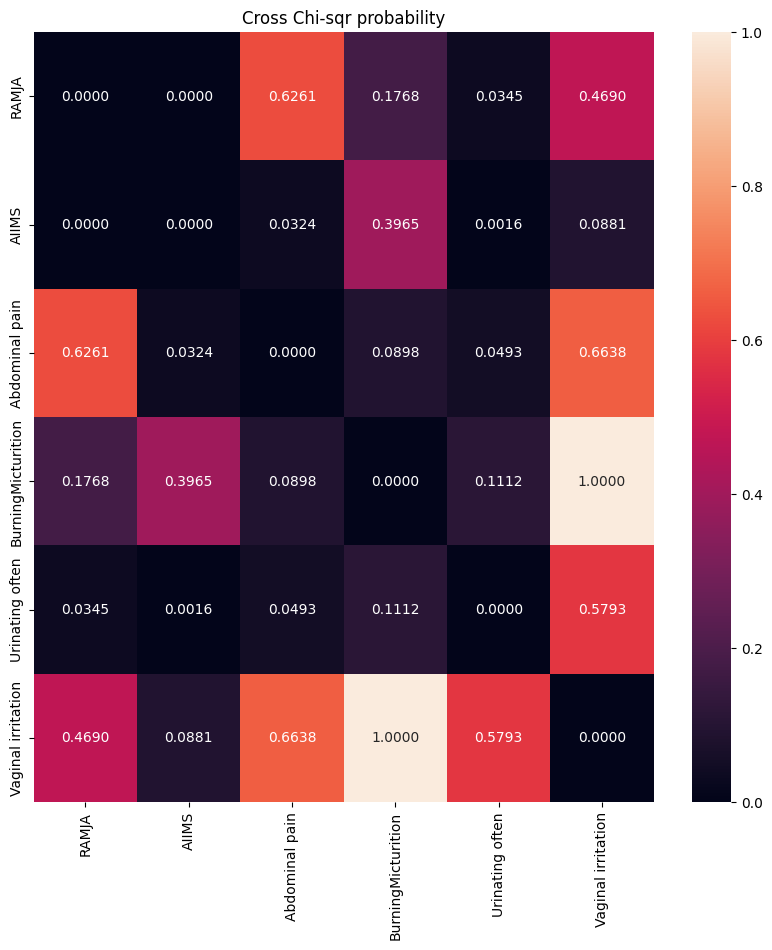

In [268]:
plot_prob(df_sym_corr)

Else condition Met:  0.9752984037440119
Else condition Met:  0.49875222854931944
Else condition Met:  0.0
Else condition Met:  0.09724180599471156
Else condition Met:  0.20052389515988858
Else condition Met:  0.0
Else condition Met:  0.49875222854931944
Else condition Met:  0.9746437668804949
Else condition Met:  0.2036136971800343
Else condition Met:  0.0
Else condition Met:  0.322572037074712
Else condition Met:  0.14854254733135988
Else condition Met:  0.0
Else condition Met:  0.2036136971800343
Else condition Met:  0.9569243834835662
Else condition Met:  0.1473151340758614
Else condition Met:  0.1821223687568199
Else condition Met:  0.0
Else condition Met:  0.09724180599471156
Else condition Met:  0.0
Else condition Met:  0.1473151340758614
Else condition Met:  0.9766607218073038
Else condition Met:  0.13320040149780654
Else condition Met:  0.0
Else condition Met:  0.20052389515988858
Else condition Met:  0.322572037074712
Else condition Met:  0.1821223687568199
Else condition Met:

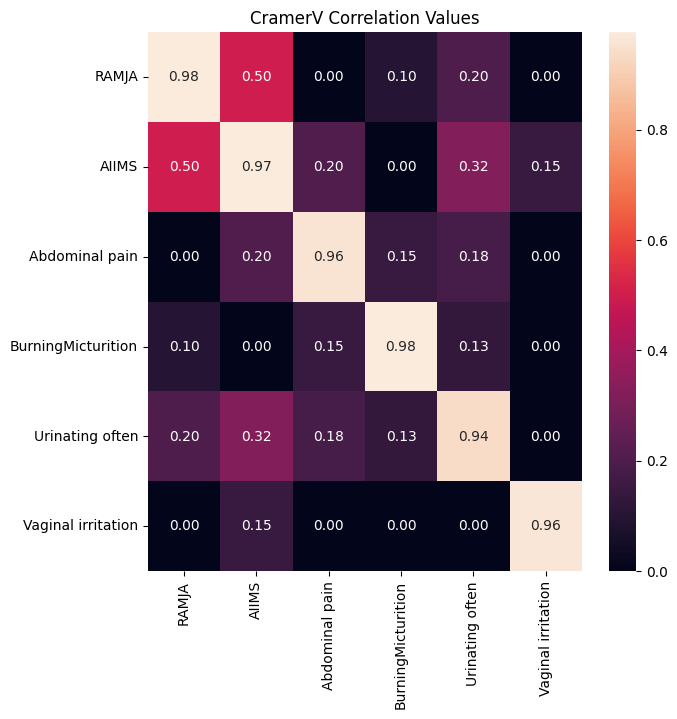

In [269]:
plot_cramer(df_sym_corr)

In [270]:
df_sym_corr.head()

,RAMJA,AIIMS,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation
0,1,1,1,1,1,0
1,1,1,0,1,0,0
2,1,0,0,1,0,1
3,1,1,0,0,0,1
4,1,1,0,1,1,0


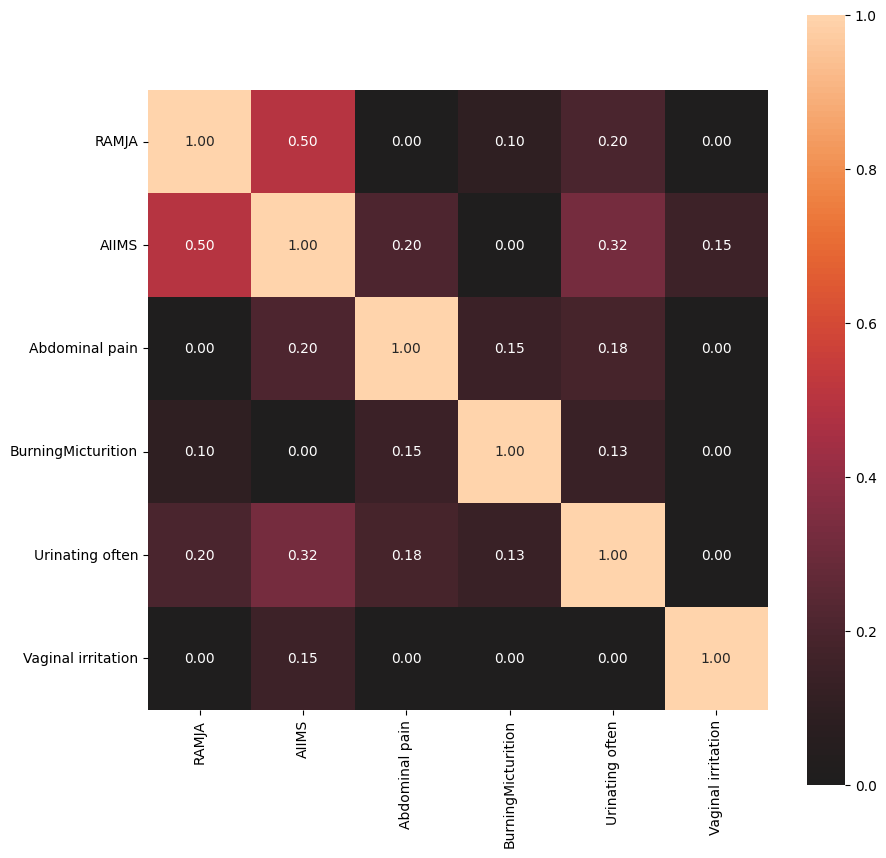

{'corr':                        RAMJA     AIIMS  Abdominal pain  BurningMicturition  \
 RAMJA               1.000000  0.498752        0.000000            0.097242   
 AIIMS               0.498752  1.000000        0.203614            0.000000   
 Abdominal pain      0.000000  0.203614        1.000000            0.147315   
 BurningMicturition  0.097242  0.000000        0.147315            1.000000   
 Urinating often     0.200524  0.322572        0.182122            0.133200   
 Vaginal irritation  0.000000  0.148543        0.000000            0.000000   
 
                     Urinating often  Vaginal irritation  
 RAMJA                      0.200524            0.000000  
 AIIMS                      0.322572            0.148543  
 Abdominal pain             0.182122            0.000000  
 BurningMicturition         0.133200            0.000000  
 Urinating often            1.000000            0.000000  
 Vaginal irritation         0.000000            1.000000  ,
 'ax': <Axes: >}

In [271]:
from dython.nominal import associations
associations(df_sym_corr, nominal_columns='all', figsize=(10,10) )

### Control for specificity

In [110]:
# Load the data into a DataFrame
df_ctrl = pd.read_excel('RAWLOT1.xlsx', sheet_name='Control')
df_ctrl.head()

,UHID,Patients Name,Age,Gender,RAMJA Result,AIIMS Result culture,E.coli,K. Pneumoniae,P.aurogenosa,A.baumnnii,P.mirabilis,S. aureus,E.faecalis,S. saprophyticus,Diagnosis
0,20170059075,Laxmi,34,F,Sterile,Sterile,-5.41,-7.42,-7.85,-5.64,-6.67,-6.34,-3.18,-0.03,NO
1,20210062776,Nasrin Jahan,32,F,Sterile,Sterile,-5.60,-2.70,-6.70,-6.20,-6.70,-7.50,-6.40,-9.70,NO
2,20240043449,Dharamwati,54,F,Sterile,Sterile,NaN,-8.70,-7.90,-7.50,-6.90,-9.70,-7.50,-9.20,NO
3,20240076642,Kiran,43,F,Sterile,Sterile,-3.66,0.00,-6.01,-7.52,-5.95,-4.18,0.00,-4.50,NO
4,20240094375,Seema devi,49,F,Sterile,Sterile,-4.81,-6.40,-9.24,-7.92,-7.64,-6.12,-3.57,-1.88,NO


In [111]:
df_ctrl = df_ctrl[['UHID','RAMJA Result', 'AIIMS Result culture', 'Diagnosis']].rename(columns={'RAMJA Result':'RAMJA','AIIMS Result culture':'AIIMS'})
df_ctrl['Diagnosis'] = df_ctrl['Diagnosis'].map(lambda x: 0 if x=='NO' else 1)
df_ctrl

,UHID,RAMJA,AIIMS,Diagnosis
0,20170059075,Sterile,Sterile,0
1,20210062776,Sterile,Sterile,0
2,20240043449,Sterile,Sterile,0
3,20240076642,Sterile,Sterile,0
4,20240094375,Sterile,Sterile,0
5,20240092862,Sterile,Sterile,0
6,20240070180,Sterile,Sterile,0
7,20240118730,Sterile,E.coli,0
8,20240101716,Sterile,Contamination,0
9,20240043267,NaN,Enterococcus faecium,0


In [112]:
test = ['RAMJA', 'AIIMS']

# Create a dictionary to store results dynamically
df_dict_ctrl = {}

# Store the result with a dynamic key
for t in test:
    df_dict_ctrl['df' + t] = processdata(df_ctrl, t)

df_ctrl_R = df_dict_ctrl['dfRAMJA']
df_ctrl_A = df_dict_ctrl['dfAIIMS']

df_ctrl_R['Diagnosis'] = df_ctrl['Diagnosis']
df_ctrl_A['Diagnosis'] = df_ctrl['Diagnosis']

C:\Users\neelesh\AppData\Local\Temp\ipykernel_13280\488496531.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean'+test] = df[test].apply(cleanup)
C:\Users\neelesh\AppData\Local\Temp\ipykernel_13280\488496531.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean'+test] = df[test].apply(cleanup)


In [113]:

df_ctrl_NonNaN_A = df_ctrl_A.dropna()[['UHID','AIIMS','Positive','Negative', 'Diagnosis']]
df_ctrl_NonNaN_R = df_ctrl_R.dropna()[['UHID','RAMJA','Positive','Negative', 'Diagnosis']]

df_ctrl_NonNaN_R.head()

,UHID,RAMJA,Positive,Negative,Diagnosis
0,20170059075,Sterile,0,1,0
1,20210062776,Sterile,0,1,0
2,20240043449,Sterile,0,1,0
3,20240076642,Sterile,0,1,0
4,20240094375,Sterile,0,1,0


In [114]:
df_ctrl_NonNaN_R[['Positive','Diagnosis']].value_counts()

Positive  Diagnosis
0         0            12
dtype: int64

In [115]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
def scores_ctrl(y_true, y_pred):
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Check if confusion matrix is 2x2 or not
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()             
        else:
            # Handle case where all values are the same (e.g., all 0s)
            tn = cm[0, 0]  # True negatives are the only relevant value
            fp = fn = tp = 0  # All other counts are 0         
                
        #.....................Accuracy......................#
        #accur = accuracy_score(y_test,y_pred)
        accur = (tp + tn)/(tp+tn+fp+fn)
        
             #.....................Senstivity.....................#
        sens = tp/(tp + fn) if (tp + fn) > 0 else 0

        #.....................Specificity...................#
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

        #..........Positive predictive value (PPV)...........#
        PPV = tp/(tp + fp) if (tp + fp) > 0 else 0

        #..........negative predictive value (NPV)...........#
        NPV = tn/(tn + fn) if (tn + fn) > 0 else 0
        
        #..........Positive Likelihood ratio (PLR)...........#
        PLR = sens/(1-spec)

        #..........Negative Likelihood ratio (NLR)...........#
        NLR = (1-sens)/spec

        errorList = np.array([accur, sens, spec, PPV, NPV, PLR, NLR])
        scoreid = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'PLR', 'NLR']
        df_scores = pd.DataFrame(errorList,index=scoreid, columns= ['Scores'])
        
        return(df_scores)

In [47]:
y_true = df_ctrl_NonNaN_R['Diagnosis']
y_pred = df_ctrl_NonNaN_R['Positive']
df_ctrl_scores_R = scores_ctrl(y_true,y_pred)
df_ctrl_scores_R

C:\Users\neelesh\AppData\Local\Temp\ipykernel_5592\228116685.py:31: RuntimeWarning: invalid value encountered in double_scalars
  PLR = sens/(1-spec)


,Scores
Accuracy,1.0
Sensitivity,0.0
Specificity,1.0
PPV,0.0
NPV,1.0
PLR,NaN
NLR,1.0


In [63]:
#...Scores matrix AIIMS
y_true = df_ctrl_NonNaN_A['Diagnosis']
y_pred = df_ctrl_NonNaN_A['Positive']

df_ctrl_scores_A = scores_ctrl(y_true,y_pred)
df_ctrl_scores_A

,Scores
Accuracy,0.857143
Sensitivity,0.000000
Specificity,0.857143
PPV,0.000000
NPV,1.000000
PLR,0.000000
NLR,1.166667


In [65]:
confusion_matrix(y_true, y_pred).ravel()

array([12,  2,  0,  0], dtype=int64)

In [67]:
#...Confusion matrix AIIMS
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
t_cm_A = np.array([tp, fp, fn, tn]).reshape(2,2)
df_cm_A =pd.DataFrame(t_cm_A,index=['AIIMS Positive','AIIMS Negative'], columns= ['True Positive','True Negative'])
df_cm_A

,True Positive,True Negative
AIIMS Positive,0,2
AIIMS Negative,0,12


In [116]:
temp_ctrl_R = df_ctrl_R[['UHID','Positive','Negative']].rename(columns={'Positive':'Positive_R', 'Negative':'Negative_R'})
temp_ctrl_A = df_ctrl_A[['UHID','Positive','Negative']].rename(columns={'Positive':'Positive_A', 'Negative':'Negative_A'})
temp_ctrl_C = pd.merge(temp_ctrl_A, temp_ctrl_R, how='inner', on='UHID')
df_ctrl = pd.merge(df_ctrl, temp_C, how='inner', on='UHID')
df_ctrl

,UHID,RAMJA,AIIMS,Diagnosis,Positive_A,Negative_A,Positive_R,Negative_R
0,20170059075,Sterile,Sterile,0,0,1,0,1
1,20210062776,Sterile,Sterile,0,0,1,0,1
2,20240043449,Sterile,Sterile,0,0,1,0,1
3,20240076642,Sterile,Sterile,0,0,1,0,1
4,20240094375,Sterile,Sterile,0,0,1,0,1
5,20240092862,Sterile,Sterile,0,0,1,0,1
6,20240070180,Sterile,Sterile,0,0,1,0,1
7,20240118730,Sterile,E.coli,0,1,0,0,1
8,20240101716,Sterile,Contamination,0,0,1,0,1
9,20240043267,NaN,Enterococcus faecium,0,1,0,0,0


In [117]:
df_ctrl_NAN_C = df_ctrl.dropna(subset=['RAMJA','AIIMS'], axis=0)
df_ctrl_NAN_C.shape

(12, 8)

In [120]:

df_ctrl_Neg_C = df_ctrl_NAN_C[(df_ctrl_NAN_C['Negative_R'] == 1) & (df_ctrl_NAN_C['Negative_A'] ==1)]
df_ctrl_Neg_C.shape

(11, 8)

In [121]:
df_ctrl_Pos_C = df_ctrl_NAN_C[(df_ctrl_NAN_C['Positive_R'] == 1) & (df_ctrl_NAN_C['Positive_A'] == 1)]
df_ctrl_Pos_C.shape

(0, 8)

In [56]:
df_ctrl_Pos_A = df_ctrl_A[(df_ctrl_A['Positive'] == 1) & (df_ctrl_A['Diagnosis'] == 0)]
df_ctrl_Pos_A.shape

(2, 18)

In [122]:
df_ctrl_Pos_R_Neg_A = df_ctrl_NAN_C[(df_ctrl_NAN_C['Positive_R'] == 1) & (df_ctrl_NAN_C['Negative_A'] == 1)]
df_ctrl_Pos_R_Neg_A.shape

(0, 8)

In [123]:
df_ctrl_Neg_R_Pos_A = df_ctrl_NAN_C[(df_ctrl_NAN_C['Negative_R'] == 1) & (df_ctrl_NAN_C['Positive_A'] == 1)]
df_ctrl_Neg_R_Pos_A.shape

(1, 8)

In [57]:
df_ctrl_Neg_C.head()

,UHID,RAMJA,AIIMS,Diagnosis,Positive_A,Negative_A,Positive_R,Negative_R
0,20170059075,Sterile,Sterile,0,0,1,0,1
1,20210062776,Sterile,Sterile,0,0,1,0,1
2,20240043449,Sterile,Sterile,0,0,1,0,1
3,20240076642,Sterile,Sterile,0,0,1,0,1
4,20240094375,Sterile,Sterile,0,0,1,0,1


In [130]:
y_true = df_ctrl_NAN_C['Diagnosis']
y_pred = df_ctrl_NAN_C['Positive_R']
df_ctrl_scores_R = scores_ctrl(y_true,y_pred)
df_ctrl_scores_R

C:\Users\neelesh\AppData\Local\Temp\ipykernel_13280\228116685.py:31: RuntimeWarning: invalid value encountered in double_scalars
  PLR = sens/(1-spec)


,Scores
Accuracy,1.0
Sensitivity,0.0
Specificity,1.0
PPV,0.0
NPV,1.0
PLR,NaN
NLR,1.0


In [131]:
#...Scores matrix AIIMS
y_true = df_ctrl_NAN_C['Diagnosis']
y_pred = df_ctrl_NAN_C['Positive_A']

df_ctrl_scores_A = scores_ctrl(y_true,y_pred)
df_ctrl_scores_A

,Scores
Accuracy,0.916667
Sensitivity,0.000000
Specificity,0.916667
PPV,0.000000
NPV,1.000000
PLR,0.000000
NLR,1.090909


In [132]:
confusion_matrix(y_true, y_pred).ravel()

array([11,  1,  0,  0], dtype=int64)

In [133]:
#...Confusion matrix AIIMS
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
t_cm_A = np.array([tp, fp, fn, tn]).reshape(2,2)
df_cm_A =pd.DataFrame(t_cm_A,index=['AIIMS Positive','AIIMS Negative'], columns= ['True Positive','True Negative'])
df_cm_A

,True Positive,True Negative
AIIMS Positive,0,1
AIIMS Negative,0,11


In [125]:
samplesDetailCtrl = {
    #"Total Samples": [data.shape[0],data.shape[0]],
    #"Blank Results": [data['RAMJA'].isnull().sum(axis=0), data['AIIMS'].isnull().sum(axis=0)],
    #"Non-Blank Results": [data['RAMJA'].count(),data['AIIMS'].count()],
    #"Contaminated Samples [-Ve]": [df_NonNaN_R['Contamination'].sum(),df_NonNaN_A['Contamination'].sum()],
    #"Others [+Ve]": [df_NonNaN_R['Others'].sum(),df_NonNaN_A['Others'].sum()],
    "Total common samples":  [df_ctrl_NAN_C.shape[0]],
    #"Useful Samples":[df_R_clean.shape[0], df_A_clean.shape[0]],
    "Positive": [df_ctrl_NAN_C['Positive_R'].sum(),df_ctrl_NAN_C['Positive_A'].sum()],
    "Negative": [df_ctrl_NAN_C['Negative_R'].sum(),df_ctrl_NAN_C['Negative_A'].sum()],
    "Common Positive": [df_ctrl_Pos_C.shape[0]],
    #"Concordance [Common bacteria]": [df_C['concordance'].sum()],
    "Common Negative": [df_ctrl_Neg_C.shape[0]],
    "RAMJA Positive and AIIMS Negative":[df_ctrl_Pos_R_Neg_A.shape[0]],
    "RAMJA Negative and AIIMS Positive":[df_ctrl_Neg_R_Pos_A.shape[0]]
    
}

In [126]:
df_samplesDetail_C = pd.DataFrame(samplesDetailCtrl, index=['RAMJA','AIIMS']).T
df_samplesDetail_C

,RAMJA,AIIMS
Total common samples,12,12
Positive,0,1
Negative,12,11
Common Positive,0,0
Common Negative,11,11
RAMJA Positive and AIIMS Negative,0,0
RAMJA Negative and AIIMS Positive,1,1


In [134]:
with pd.ExcelWriter('2controlmatrices.xlsx') as writer:
    df_samplesDetail_C.to_excel(writer, sheet_name='ControlSamples', index=True)
    df_ctrl_scores_R.to_excel(writer, sheet_name='ControlRAMJA', index=True)
    df_ctrl_scores_A.to_excel(writer, sheet_name='ControlAIIMS', index=True)

### ROC

### get dataset 

In [39]:
data_score_temp = dataset.iloc[:,[0] + list(range(6,14))]
data_score_temp['minimum'] = data_score_temp.iloc[:, 0:8].min(axis=1)
temp_scores = pd.merge(data_score_temp, df_NonNaN_A.drop(['AIIMS', 'cleanAIIMS', 'Sterile', 'Contamination', 'NAN', 'Others', 'Positive', 'Negative' ], axis=1), how='inner', on='UHID')
data_ROC = pd.merge(temp_scores,df_NonNaN_C[['UHID','Positive_R', 'Positive_A']], how='inner', on='UHID')
data_ROC.head()

C:\Users\neelesh\AppData\Local\Temp\ipykernel_8004\957381507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_score_temp['minimum'] = data_score_temp.iloc[:, 0:8].min(axis=1)


,UHID,E.coli,K. Pneumoniae,P.aurogenosa,A.baumnnii,P.mirabilis,S. aureus,E.faecalis,S. saprophyticus,minimum,Escherichia coli,Klebsiella pneumoniae,Pseudomonas aeruginosa,Acinetobacter baumannii,Proteus mirabilis,Enterococcus faecalis,Staphylococcus aureus,Staphylococcus saprophyticus,Positive_R,Positive_A
0,20220065432,NaN,NaN,-5.26086,-4.09794,-3.58480,-5.62819,-8.10731,NaN,-8.10731,0,0,0,0,0,1,0,0,1,1
1,20230125389,-15.30980,-10.01740,-9.09993,-8.30414,-5.06676,-8.77797,-5.42121,NaN,-15.30980,1,0,0,0,0,0,0,0,1,1
2,20180022685,-7.70704,-8.08910,-4.79176,-8.63416,-11.84570,-9.90339,-9.31657,NaN,-11.84570,0,0,0,0,0,0,0,0,1,0
3,20240012395,-10.25510,-7.26028,-6.89303,-14.34320,-11.54470,-10.82420,-10.78790,NaN,-14.34320,1,0,0,0,0,0,0,0,1,1
4,20220166372,-9.04000,-5.39780,-12.27840,-8.01114,-11.00330,-11.66680,-13.59960,NaN,-13.59960,1,0,1,0,0,0,0,0,1,1


In [42]:
data_sym_ROC = df_sym.iloc[:,[0]+ list(range(8,14))]
data_sym_ROC = pd.merge(data_ROC,data_sym_ROC, how='inner', on='UHID')
data_sym_ROC.shape

(87, 26)

In [44]:
with pd.ExcelWriter('data_ROC.xlsx') as writer:
    data_ROC.to_excel(writer, sheet_name='DataROC', index=False)
    data_sym_ROC.to_excel(writer, sheet_name='SymDataROC', index=False)

In [54]:
from sklearn.metrics import roc_curve, auc
# Assuming you have a DataFrame 'dataset' with 'true_values' and 'device_scores'
# Replace 'true_values' and 'device_scores' with the actual column names
true_values = data_scores['minimum']  # Actual binary values (0 or 1)
device_scores = abs(data_scores['Positive'])  # Scores from the device, ranging from -16 to 0

# Define a cutoff for converting device scores to binary predictions (adjust based on your needs)
cutoff = 8  # Example cutoff; adjust this value based on your data distribution
predicted_labels = (device_scores >= cutoff).astype(int)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_values, device_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Print the AUC value
print(f"AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


ValueError: continuous format is not supported

In [45]:
data_scores.shape

(112, 25)

In [44]:
dataset.head()

,UHID,Patients Name,Age,Gender,RAMJA Result,AIIMS Result culture,E.coli,K. Pneumoniae,P.aurogenosa,A.baumnnii,P.mirabilis,S. aureus,E.faecalis,S. saprophyticus,Diagnosis,Abdominal pain,BurningMicturition,Urinating often,Vaginal irritation,Fatigue,Malaise,WeightLoss,Cough,Expectoration,HospitalStay,ICU Stay,Prognosis,Ventillator,Dialysis,BP
0,20220065432,Sahroj,33.0,F,Enterococcus faecalis,Enterococcus faecalis,NaN,NaN,-5.26086,-4.09794,-3.58480,-5.62819,-8.10731,NaN,UTI,Yes,Yes,Yes,No,Yes,Yes,No,No,No,Yes,0,Good,No,No,110/76
1,20240016182,Shyanu,70.0,F,NaN,NaN,-6.63325,-10.1276,-8.30086,-13.22480,-11.94120,-14.93870,-13.64090,NaN,Vaginal Hysterectomy,Yes,No,no,no,no,no,no,no,no,0,0,Good,No,No,112/76
2,20230125389,Saloni,19.0,F,E.Coli. and K.pne,E.coli,-15.30980,-10.0174,-9.09993,-8.30414,-5.06676,-8.77797,-5.42121,NaN,UTI,No,Yes,No,No,No,No,No,No,No,0,0,Good,No,No,100/60
3,20180022685,Ravita,34.0,F,P. mirabilis,CONTAMINATION,-7.70704,-8.0891,-4.79176,-8.63416,-11.84570,-9.90339,-9.31657,NaN,UTI,No,Yes,No,Yes,No,No,No,No,No,0,0,Good,No,No,105/80
4,20201415102,Jyoti,28.0,F,NaN,NaN,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,UTI,No,No,No,No,No,No,No,No,No,0,0,Good,No,No,115/100


In [54]:
df_ROC = dataset.iloc[:,6:14]
df_ROC.columns = ['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus']
df_ROC['UHID'] = dataset['UHID']

In [55]:
df_ROC = pd.merge(df_ROC, df_NonNaN_C, how='inner', on='UHID')

In [50]:
df_ROC.shape

(112, 16)

In [51]:
df_ROC.head()

,Escherichia coli,Klebsiella pneumoniae,Pseudomonas aeruginosa,Acinetobacter baumannii,Proteus mirabilis,Enterococcus faecalis,Staphylococcus aureus,Staphylococcus saprophyticus,UHID,RAMJA,AIIMS,concordance,Positive_A,Negative_A,Positive_R,Negative_R
0,NaN,NaN,-5.26086,-4.09794,-3.58480,-5.62819,-8.10731,NaN,20220065432,Enterococcus faecalis,Enterococcus faecalis,1,1,0,1,0
1,-15.30980,-10.01740,-9.09993,-8.30414,-5.06676,-8.77797,-5.42121,NaN,20230125389,E.Coli. and K.pne,E.coli,1,1,0,1,0
2,-7.70704,-8.08910,-4.79176,-8.63416,-11.84570,-9.90339,-9.31657,NaN,20180022685,P. mirabilis,CONTAMINATION,0,0,1,1,0
3,-10.25510,-7.26028,-6.89303,-14.34320,-11.54470,-10.82420,-10.78790,NaN,20240012395,"Polymicrobial (E.coli, A. baumannii, P.mirabil...",E.coli,1,1,0,1,0
4,-9.04000,-5.39780,-12.27840,-8.01114,-11.00330,-11.66680,-13.59960,NaN,20220166372,"E.coli, Pseudomonas, P.mirabilis, E.Faecalis, ...",E.coli & Pseudomnas,1,1,0,1,0


In [56]:
df_ROC =df_ROC[['Escherichia coli','Klebsiella pneumoniae','Pseudomonas aeruginosa','Acinetobacter baumannii','Proteus mirabilis','Enterococcus faecalis','Staphylococcus aureus','Staphylococcus saprophyticus','Positive_R']]
df_ROC = df_ROC.drop(['Staphylococcus saprophyticus'], axis=1)
df_ROC.head()

,Escherichia coli,Klebsiella pneumoniae,Pseudomonas aeruginosa,Acinetobacter baumannii,Proteus mirabilis,Enterococcus faecalis,Staphylococcus aureus,Positive_R
0,NaN,NaN,-5.26086,-4.09794,-3.58480,-5.62819,-8.10731,1
1,-15.30980,-10.01740,-9.09993,-8.30414,-5.06676,-8.77797,-5.42121,1
2,-7.70704,-8.08910,-4.79176,-8.63416,-11.84570,-9.90339,-9.31657,1
3,-10.25510,-7.26028,-6.89303,-14.34320,-11.54470,-10.82420,-10.78790,1
4,-9.04000,-5.39780,-12.27840,-8.01114,-11.00330,-11.66680,-13.59960,1


In [57]:
df_ROC = df_ROC.dropna()

In [58]:
df_ROC.shape

(107, 8)

In [60]:
#..............Assigning X and Y variables...........#
x = df_ROC.drop(['Positive_R'], axis=1)
y = np.array(df_ROC['Positive_R']).reshape(-1,1) 

In [71]:
#.............Split train and test sets..............#
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=25, stratify=y)

In [72]:
#...............Feature scaling..................#
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [94]:
#...............Training..................#
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(x_train,y_train)

#.......Predict the Test set result.......#
#y_pred = classifier.predict(x_test).reshape(-1, 1)
y_pred = (classifier.predict_proba(x_test)[:, 1] >= 0.5).astype(int).reshape(-1, 1)
#y_pred_prob = classifier.predict_proba(x_test)[:, 1] #Only keep the first column, which is the 'pos' values
#y_pred_prob = (classifier.predict_proba(x_test)[:, 1] >= 0.2).astype(int).reshape(-1, 1)

c:\Users\neelesh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
y_pred.shape

(33, 1)

In [95]:
y_pred_prob=classifier.predict_proba(x_test)[:, 1].reshape(-1, 1)

In [96]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def rocplot(y_test, y_pred_prob):
    # calculate AUC
    auc = round(roc_auc_score(y_test, y_pred_prob),4)

    y_test_auc = roc_auc_score(y_test,y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    plt.plot(fpr, tpr, label="Logistic, AUC="+str(auc))

    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for E. coli classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    # show the legend
    plt.legend()

    # fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # plt.plot(fpr, tpr)
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.0])
    # plt.rcParams['font.size'] = 12
    # plt.title('ROC curve for diabetes classifier')
    # plt.xlabel('False Positive Rate (1 - Specificity)')
    # plt.ylabel('True Positive Rate (Sensitivity)')
    # plt.grid(True)

    

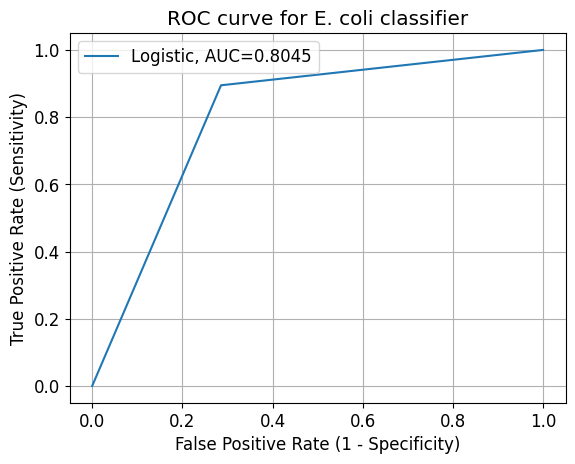

In [97]:
rocplot(y_test, y_pred)

(0.0, 1.0)

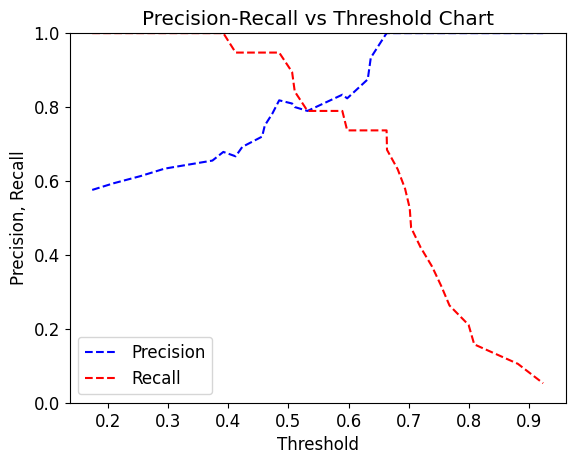

In [84]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

#### ................Finish.....................